In [1]:
import sys,os

In [2]:
sys.path.append(os.path.abspath('/Users/charleslaroche/Documents/GitHub/Internship-at-CREST/PROCEDURE'))

In [3]:
import nbimporter
import numpy as np
import numpy.random as alea
import random as rd
import matplotlib.pyplot as plt
from math import *
import progressbar
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from procedure_MOM import * 
from random_data import *
from sklearn.model_selection import train_test_split
plt.style.use("seaborn-darkgrid")

In [4]:
class MOM_LASSO():
    
    def __init__(self , K): 
        
        self.K = K
        self.iter_max = 200
        self.params = {}
    
    def fit(self , X , Y , lamb = 1 , method = "ADMM" , step_size = 0.001 , initialize = "zero"):
        
        n,p = np.shape(X)
        j = n // self.K
        self.lamb = lamb
        
        if initialize == "zero":
            t = np.matrix(np.zeros((p,1)))
        
        if method == "ADMM" : 
                
            z = np.matrix(np.zeros((p,1))) 
            u = np.matrix(np.zeros((p,1))) 
            rhoM = 5 * np.identity(p)
            
            for l in range(self.iter_max) :
                
                k = MOM(P_quadra(X , Y , t) , self.K)[1]
                Xk = X[k]
                Yk = Y[k]
                
                t = np.linalg.solve((Xk.T) @ Xk  +  rhoM, (Xk.T) @ Yk  +  5 * z  -  u)
                z = soft_thresholding(lamb / 5,t + u / 5)
                u = u + 5 * (t - z)

            self.t = t
            print("Training finished")
                
        if method == "ISTA" :
            
            for l in range(self.iter_max) :
                
                k = MOM(P_quadra( X , Y , t ) , self.K)[1] 
                Xk = X[k]
                Yk = Y[k]
                
                #Beginning of backtracking with c = 1/2
                gamma = 1
                t_prev = t
                F = quadra_loss(Xk , Yk , t_prev)
                
                t = soft_thresholding(self.lamb * gamma,t - gamma * grad(Xk , Yk , t))
                delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
                
                while delta > 1e-3 :
                    
                    gamma *= mu
                    t = soft_thresholding(self.lamb * gamma , t_prev - gamma * grad(Xk , Yk , t_prev))
                    delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma))*np.linalg.norm(t - t_prev) ** 2
                
            self.t = t
            print("Training finished")
            
        if method == "FISTA" :
            
            for l in range(nmax) :
            
                #Block detection
                k = MOM(P_quadra(X , Y , t) , self.K)[1] 
                Xk = X[k]
                Yk = Y[k]
                #Beginning of backtracking with c = 1/2
                gamma = 1
                t_prev = t
                F = quadra_loss(Xk , Yk , t_prev)
                
                t = soft_thresholding(self.lamb * gamma , z - gamma * grad(Xk , Yk , z))
                delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
                
                while delta > 1e-3 :
                    
                    gamma *= mu
                    t = soft_thresholding(self.lamb * gamma,z - gamma * grad(Xk , Yk , z))
                    delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
                    
                z = t + (l / (l + 3)) * (t - t_prev) 
                
            self.t = t
            print("Training finished")
            
        if method == "SUBGRAD" :
             
            for l in range(self.iter_max) :
                
                k = MOM(P_quadra(X , Y , t) , self.K)[1] 
                Xk = X[k]
                Yk = Y[k]
                   
                t = t - step_size * subgrad(Xk , Yk , t , self.lamb) / np.sqrt(l + 1)  
                   
            self.t = t
            print("Training finished")
    
    def predict(self , X):
        
        return X * self.t
    
    def score(self , X , Y):
        
        return quadra_loss(X , Y , self.t)
    
    def get_params(deep = False):
        pass
        

In [5]:
iter_max = 200
n = 200
n_outliers = 3
features  =  50
sparsity  =  10
lamb  =  1
K1  =  5
K2  =  7
step_size1  =  0.01
step_size2  =  0.003
sigma  =  1
t_0  =  create_t_0(features,sparsity)
Y1,X1  =  data1(n,t_0,1)
Y1,X1  =  np.matrix(Y1),np.matrix(X1)
Y2,X2  =  data2(n_outliers,features,type_outliers  =  2)
Y2,X2  =  np.matrix(Y2),np.matrix(X2)
Y,X  =  data_merge(Y1, X1, Y2, X2)

In [6]:
model = MOM_LASSO(10)

In [7]:
model.fit(X , Y)

Training finished


### Adaptive choice of K

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [22]:
def best_K(X_train , X_test , Y_train , Y_test):
    
    _ , p = np.shape(X)
    lamb = 1/ np.sqrt(p)
    score = np.zeros(20)
    
    for K in range(1 , 41 , 2):
        
        model = MOM_LASSO(K)
        model.fit(X_train , Y_train , lamb = lamb)
        score[K//2] = model.score(X_test , Y_test)
        
    print(score)
    return (np.argmin(score) + 1) * 2

In [23]:
iter_max = 200
n = 200
n_outliers = 3
features  =  50
sparsity  =  10
lamb  =  1
K1  =  5
K2  =  7
step_size1  =  0.01
step_size2  =  0.003
sigma  =  1
t_0  =  create_t_0(features,sparsity)
Y1,X1  =  data1(n,t_0,1)
Y1,X1  =  np.matrix(Y1),np.matrix(X1)
Y2,X2  =  data2(n_outliers , features , type_outliers  =  2)
Y2,X2  =  np.matrix(Y2),np.matrix(X2)

X_train , X_test , Y_train , Y_test = train_test_split(X1 , Y1)


Y_train , X_train  = data_merge(Y_train, X_train, Y2, X2)

best_K(X_train , X_test , Y_train , Y_test)

Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
[4.11719390e+07 1.16868962e+07 1.31385636e+08 8.48180128e+07
 8.25092296e+01 6.44103634e+01 8.90323626e+01 7.10307025e+01
 8.64970967e+01 6.90864217e+01 8.68486316e+01 1.41514279e+02
 1.07301412e+02 9.79234552e+01 1.60264351e+02 1.27753636e+02
 1.57947658e+02 1.56179338e+02 1.39051744e+02 2.90537153e+02]


12

### Test of the robustness

In [24]:
import numpy.linalg

In [25]:
from sklearn.linear_model import Lasso

In [26]:
n = 20000
sparsity  =  10
features  =  50
lamb  =  1 / np.sqrt(50)
sigma  =  1
t_0  =  create_t_0(features , sparsity)
Y1 , X1  =  data1(n , t_0 , sigma)
Y1 , X1  =  np.matrix(Y1) , np.matrix(X1)
score_MOM = []
score = []

for n_outliers in range(20) : 
    
    t_0  =  create_t_0(features,sparsity)
    Y1 , X1  =  data1(n,t_0,1)
    Y1 , X1  =  np.matrix(Y1),np.matrix(X1)
    Y2 , X2  =  data2(n_outliers , features , type_outliers  =  1)
    Y2 , X2  =  np.matrix(Y2) , np.matrix(X2)

    X_train , X_test , Y_train , Y_test = train_test_split(X1 , Y1)
    Y_train , X_train  = data_merge(Y_train , X_train , Y2 , X2)
     
    K = best_K(X_train , X_test , Y_train , Y_test)
    
    model = MOM_LASSO(K)
    model.fit(X_train , Y_train , lamb = lamb , method = 'SUBGRAD')
    score_MOM.append(model.score(X_test , Y_test))
    
    model_bis = Lasso(alpha = lamb)
    model_bis.fit(X_train , Y_train)
    Y_mod = model_bis.predict(X_test)
    score.append(np.linalg.norm(Y_mod - np.array(Y_test).flatten())**2)


Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
[91413.25847767  5370.99575862  5396.37334699  5424.81257736
  5466.16366148  5575.49651981  5541.85366458  5554.85484243
  5605.34108525  5605.45639212  5636.73753044  5809.99761363
  5742.16403898  5767.56850874  5824.79289175  5812.95528245
  5978.07390202  5955.90375356  5962.01519434  6278.08731142]
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training f

Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
[94914.65524825  4997.05041123  5008.03888149  5079.30400255
  5081.88874875  5180.68420272  5157.48849507  5313.5622352
  5246.54166923  5334.88331077  5220.54115703  5247.70953018
  5631.507194    5480.22945418  5440.54917434  5319.77884773
  5938.25829473  5600.92456111  5573.48831347  5612.5340572 ]
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training fi

<IPython.core.display.Javascript object>


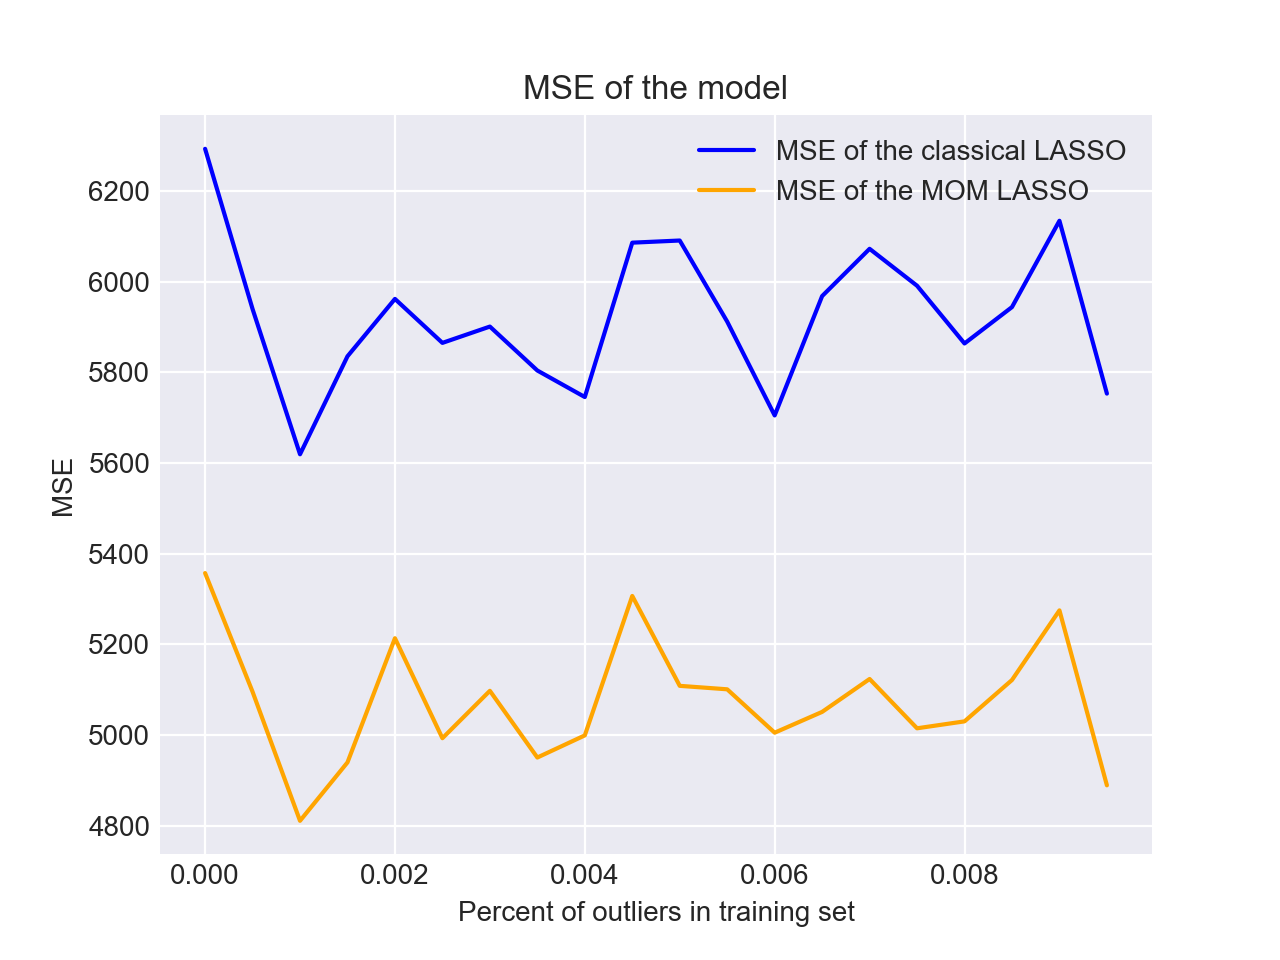

Text(0.5, 1.0, 'MSE of the model')

In [34]:
%matplotlib notebook

l = [i/2000 for i in range(20)]

plt.plot(l , score , color ='blue' , label = "MSE of the classical LASSO")
plt.plot(l , score_MOM , color ='orange' , label = "MSE of the MOM LASSO")
plt.xlabel("Percent of outliers in training set")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE of the model")
#plt.yscale('log')